In [1]:
import pandas as pd
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from pprint import pprint
from collections import defaultdict
from itertools import product


## If you also need to run the alignment of titered strains:
# from Bio.Alphabet import DNAAlphabet
# from Bio import SeqIO
# from Bio.Seq import Seq
# import os

In [2]:
titerfile = open('/Users/Sidney/nextstrain/fauna/data/dengue_titers.tsv', 'r')
alignmentfile = open('./smith_E_prot_aln.fasta', 'r')

In [3]:
## Read in, parse titer datafile (augur format tsv)
raw_titers = pd.read_csv(titerfile, sep='\t', header=None,
                    names=['virus', 'serum', 'serumID', 'src', 'titer'])
raw_titers = raw_titers.where((pd.notnull(raw_titers)), None) # Replace NaN with None to avoid unexpected behavior
raw_titers['serumID'].replace('DENV.*', 'agm', regex=True, inplace=True) # All the values with the strain name as serum ID are from AGMs
raw_titers['serumID'] = raw_titers['serum']+'|'+raw_titers['serumID'] # SerumStrain|patientID or SerumStrain|agm (1 monkey per strain used)
raw_titers.drop('serum', axis=1, inplace=True) # Cleanup
raw_titers.drop('src', axis=1, inplace=True)
raw_titers = raw_titers.to_dict(orient='records') #[{'serumID': 'DENV1/VIETNAM/BIDV1937/2008_agm', 'virus': 'DENV1/BOLIVIA/FSB3363/2010', 'titer': 29}, ...]

In [4]:
serum_strains = list(set([ record['serumID'] for record in raw_titers ]))
virus_strains = list(set([ record['virus'] for record in raw_titers ]))

In [5]:
### Run alignment (if needed; also import extra modules above)

# all_titered_strains = set([s.split('|')[0] for s in serum_strains] + virus_strains)
# all_sequences = { s.description.split('|')[0] : s for s in SeqIO.parse('/Users/Sidney/nextstrain/fauna/data/dengue.fasta', 'fasta')}

# titered_sequences = [ all_sequences[s] for s in all_titered_strains ]
# for s in titered_sequences:
#     s.seq = Seq(str(s.seq).replace('-', ''), alphabet=DNAAlphabet())
#     s.seq.translate()
# SeqIO.write(titered_sequences, open('titered_prot.fasta', 'w'), 'fasta')

# import os
# os.system('mafft titered_prot.fasta > titered_prot_aln.fasta')

In [6]:
## Read in protein alignment, calculate divergence values, set order of strains.

prot_aln = AlignIO.read(alignmentfile, 'fasta') # Read in protein alignment
divergence = DistanceCalculator('blosum62').get_distance(prot_aln) # Blosum62 scoring
order = [s.split('|')[0] for s in divergence.names] # Truncate to strain names
divergence = pd.DataFrame(divergence.matrix, columns=order, index=order)

In [7]:
## Make a design matrix formatted dataframe with rows and columns ordered by divergence (i.e., tree order)
serum_strains.sort(key=lambda x: order.index(x.split('|')[0]))
virus_strains.sort(key=lambda x: order.index(x))
raw_titers_matrix = pd.DataFrame(columns=serum_strains, index=virus_strains, dtype=float)
for record in raw_titers:
    raw_titers_matrix.at[record['virus'], record['serumID']] = record['titer']
log2_titers_matrix = raw_titers_matrix.applymap(np.log2) # Put everything on a log2 scale.

In [8]:
def normalize_autologous(series):
    ''' Normalize to autologous titers; return np.nan for columns missing autologous titers.'''
    strain = series.name.split('|')[0]
    if np.isnan(series[strain]):
        return series.map(lambda x: np.nan) # set the whole column to NaN if we're missing the autologous titer; drop it later.
    else:
        autologous = series[strain]
        return series.map(lambda x: autologous - x)

def normalize_max(series):
    ''' Normalize to max value in the row (i.e., the most reactive serum tested). '''
    max_titer = series.max()
    return series.map(lambda x: max_titer - x)

In [9]:
## Normalize both ways, remember to drop empty columns.
autologous_normalized_titers_matrix = log2_titers_matrix.apply(normalize_autologous, axis=0)
# autologous_normalized_titers_matrix.dropna(how='all', axis=0, inplace=True) # Drop columns that didn't have an autologous titer.
max_normalized_titers_matrix = log2_titers_matrix.apply(normalize_max, axis=0)
datasets = [('divergence', divergence),
                     ('raw', raw_titers_matrix),
                     ('log2_raw', log2_titers_matrix),
                     ('log2_autologous', autologous_normalized_titers_matrix), 
                     ('log2_max', max_normalized_titers_matrix)]


In [10]:
def split_serotypes(df):
    '''Return dictionary of {virus_rows: {sera_column: df}} for plotting heatmap small multiples'''
    columns = { s : [ i for i in df.columns.values if i.startswith('DENV%d'%s) ] for s in [1,2,3,4] }
    rows = { s : [i for i in df.index.values if i.startswith('DENV%d'%s) ] for s in [1,2,3,4] }
    split_serotypes = {1: {}, 2: {}, 3: {}, 4: {}} # { serotype_1_viruses: {vs_serotype_1_sera: partial_df, vs_2: ...}, ...}
    
    for serum_serotype in [1,2,3,4]:
        for virus_serotype in [1,2,3,4]:
            partial_design_matrix = df.loc[rows[virus_serotype], columns[serum_serotype]]
            split_serotypes[serum_serotype][virus_serotype] = partial_design_matrix
    return split_serotypes

In [11]:
## Cleanup. Once we no longer need to match on names, we can shorten them before making figures.
# shortened_names = { s : s.split('/')[0]+'/'+s.split('/')[3] for s in serum_strains+virus_strains }
# for name, matrix in datasets:
#     matrix.rename(columns=shortened_names, index=shortened_names, inplace=True)

In [12]:
def calc_fst(data):
    split_data = split_serotypes(data)
    
    within_sum = 0
    within_counts = 0
    
    between_sum = 0
    between_counts = 0

    for virus in [1,2,3,4]:
        for serum in [1,2,3,4]:
            df = split_data[virus][serum]
            values = [v for v in df.values.flatten() if not np.isnan(v)]
            sum_value = sum(values)
            count_value = len(values)

            if virus == serum:
                within_sum += sum_value
                within_counts += count_value
            else:
                between_sum += sum_value
                between_counts += count_value
    within = float(within_sum) / float(within_counts)
    between = float(between_sum) / float(between_counts)
    fst = (between - within) / between
    return (within, between, fst)

fst_vals = { name: calc_fst(matrix) for name, matrix in datasets if name != 'divergence' }
pprint(fst_vals)

{'log2_autologous': (0.09791788138234629,
                     1.2039339742998294,
                     0.9186683958816826),
 'log2_max': (1.9520415577034855, 2.923006138271377, 0.3321801373780575),
 'log2_raw': (5.13445274762208, 3.9146676550958635, -0.31159352466061296),
 'raw': (59.74914089347079, 18.272727272727273, -2.2698534817322322)}


In [13]:
sns.set_style('dark')
def plot_small_multiples(data, title, fname = None, cmap_r=False):
    ## Set subplot size ratios
    data = split_serotypes(data)
    width_ratios = [ len(data[i][1].columns.values) for i in [1,2,3,4] ]
    max_w = max(width_ratios)
    width_ratios = [ i / float(max_w) for i in width_ratios ]
    height_ratios = [ len(data[1][i].index.values) for i in [1,2,3,4]]
    max_h = max(height_ratios)
    height_ratios = [ i / float(max_h) for i in height_ratios ]    
    
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(5,5), facecolor='white',
                             gridspec_kw={'wspace': 0.1, 'hspace':0.1,
                            'width_ratios': width_ratios, 'height_ratios': height_ratios})
    
    ## Set colors
#     cmap=sns.cubehelix_palette(as_cmap=True, reverse=cmap_r)#n_colors=15,light=0.6,gamma=.9, as_cmap=True,reverse=cmap_r)
    cmap_name = 'magma' if cmap_r == True else 'magma_r'
    cmap = plt.get_cmap(cmap_name)
    
    all_values = []
    for (virus, serum) in product([1,2,3,4], repeat=2):
        all_values += [i for i in data[virus][serum].values.flatten() if not np.isnan(i) ]
    vmin_val = float(min(all_values)) # Anchor color map for entire figure at global min/max values
    vmax_val = float(max(all_values))
    
    cbar_axis = fig.add_axes([1.0, 0.15, .03, 0.7])

    for virus, row in enumerate(axes, start=1):
        for serum, axis in enumerate(row, start=1):
            if virus == 1 and serum == 4:
                cbar_bool = True
            else:
                cbar_bool = False

            plot = sns.heatmap(data[serum][virus], ax=axis, 
                        vmin=vmin_val, vmax=vmax_val, cmap=cmap,
                       xticklabels = False, yticklabels=False, cbar = cbar_bool, cbar_ax=cbar_axis)
            if virus == 4:
                plot.set_xlabel(serum, fontsize=18)
            if serum == 1:
                plot.set_ylabel(virus, fontsize=18)
    fig.suptitle(title, va='top', ha='center', fontsize=20)
    if fname:
        plt.savefig(fname, bbox_inches='tight')
    plt.show()

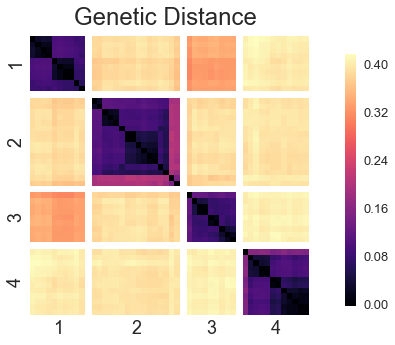

In [78]:
divergence_mirrored = divergence
for serum, series in divergence.iteritems():
    for virus, titer in series.iteritems():
        if np.isnan(titer):
            divergence_mirrored.at[virus, serum] = divergence.at[serum, virus]
plot_small_multiples(divergence, 'Genetic Distance', fname = 'divergence.png', cmap_r = True)

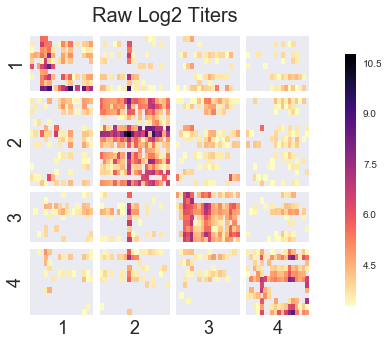

In [14]:
plot_small_multiples(log2_titers_matrix, 'Raw Log2 Titers', fname='rawlog2.png')

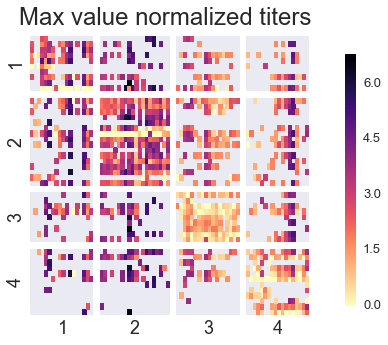

In [68]:
plot_small_multiples(max_normalized_titers_matrix, 'Max value normalized titers')

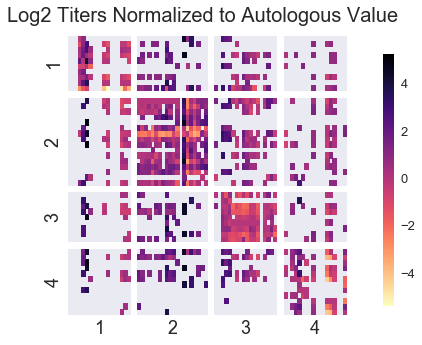

In [81]:
plot_small_multiples(autologous_normalized_titers_matrix, 'Log2 Titers Normalized to Autologous Value', fname = 'autologous_titers.png')

In [57]:
def make_tidy_data(xdf, ydf, norm):
    entries = []
    for serum, series in ydf.iteritems():
        for virus, y in series.iteritems():
            v_sero = virus.split('/')[0]
            s_sero = serum.split('/')[0]
            serotype = v_sero if v_sero == s_sero else 'heterologous'
            try:
                x = xdf.at[virus, serum.split('|')[0]]
            except:
                x = xdf.at[serum.split('|')[0], virus]
            if np.isnan(x):
                continue
            else:
                entries.append( {'Genetic Divergence': x, 'Titers': y, 'Serotype': serotype, 'Normalization': norm})
    return entries

In [19]:
colors = {'DENV1': '#DF4327',
     'DENV2': '#83BA70',
     'DENV3': '#547BD3',
     'DENV4': '#781C86',
     'heterologous': 'gray'}

def make_tidy_data(xdf, ydf, norm):
    entries = []

    for serum, series in ydf.iteritems():
        for virus, y in series.iteritems():
            v_sero = virus.split('/')[0]
            s_sero = serum.split('/')[0]            
            if s_sero == v_sero:
                serotype = s_sero
            else:
                serotype = 'heterologous'
            try:
                x = xdf.at[virus, serum.split('|')[0]]
            except:
                x = xdf.at[serum.split('|')[0], virus]
            if np.isnan(x):
                continue
            else:
                entries.append( {'Genetic Divergence': x, 'Titers': y, 
                                 'Serotype': serotype, 'Serotype Color': colors[serotype], 'Normalization': norm})
    return entries

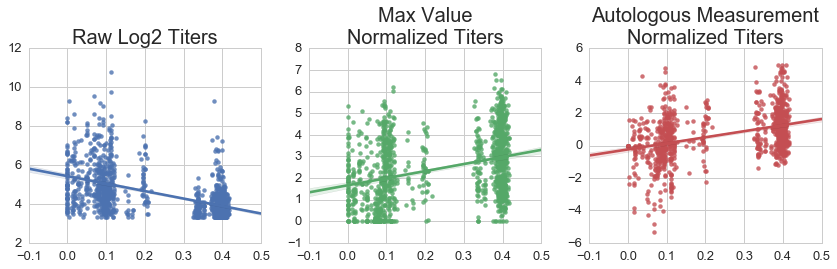

In [50]:
fig, (raw, maxnorm, autonorm) = plt.subplots(nrows=1,ncols=3, figsize=(12,4))
sns.set_style('whitegrid')
raw.set_title('Raw Log2 Titers', size=20)
maxnorm.set_title('Max Value\nNormalized Titers', size=20)
autonorm.set_title('Autologous Measurement\nNormalized Titers', size=20)

for axis, dataset, label in [(raw, log2_titers_matrix, 'Raw Log2 Titers'),
                             (maxnorm, max_normalized_titers_matrix, 'Max Value Normalized'),
                             (autonorm, autologous_normalized_titers_matrix, 'Autologous Value Normalized')]:
    points = pd.DataFrame(make_tidy_data(divergence, dataset, label))
    color_list = [ colors[s] for s in points['Serotype'] ]
    sns.regplot(points['Genetic Divergence'], points['Titers'], ax=axis) 
    axis.set_xlabel('', size=18)
    axis.set_ylabel('', size=18)
    
sns.set_style('whitegrid')
plt.tight_layout()
plt.savefig('normalized_values.png')

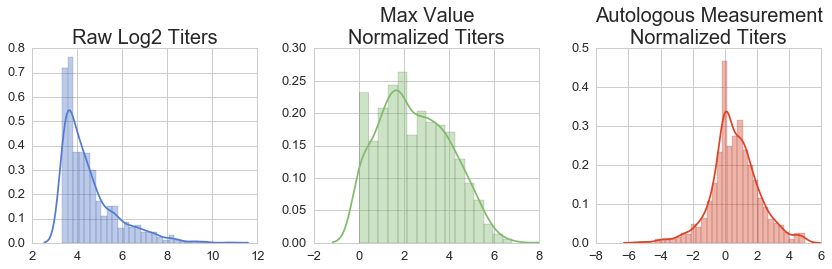

In [49]:
fig, (raw, maxnorm, autonorm) = plt.subplots(nrows=1,ncols=3, figsize=(12,4))
sns.set_style('whitegrid')
raw.set_title('Raw Log2 Titers', size=20)
maxnorm.set_title('Max Value\nNormalized Titers', size=20)
autonorm.set_title('Autologous Measurement\nNormalized Titers', size=20)

for axis, dataset in [(raw,log2_titers_matrix), (maxnorm, max_normalized_titers_matrix), 
                      (autonorm, autologous_normalized_titers_matrix)]:
    vals = pd.Series(dataset.values.flatten())
    vals.dropna(inplace=True)
    c = {raw: '#547BD3', maxnorm:'#83BA70', autonorm: '#DF4327'}[axis]
    sns.distplot(vals, ax=axis, color=c) 
    axis.set_xlabel('', size=18)
    axis.set_ylabel('', size=18)
    
sns.set_style('whitegrid')
plt.tight_layout()
plt.savefig('titers_distrib.png')

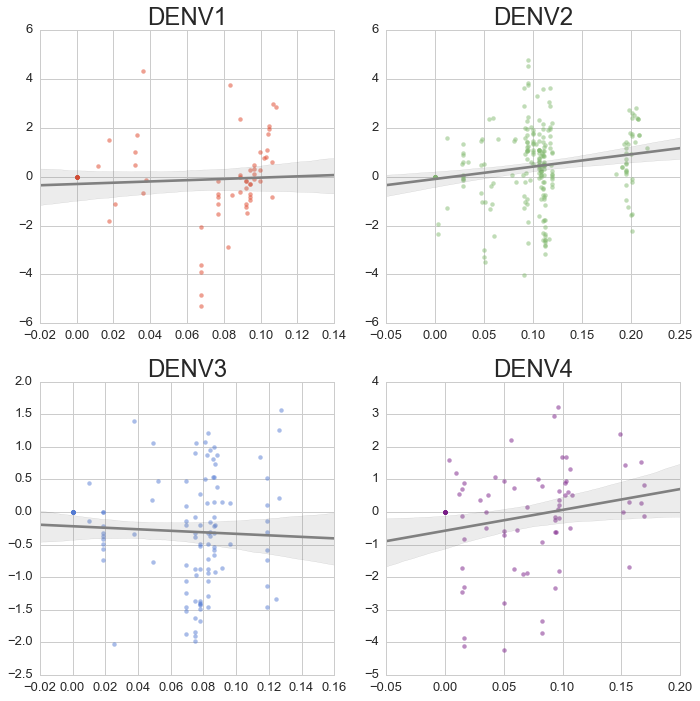

In [30]:
colors = {'DENV1': '#DF4327',
     'DENV2': '#83BA70',
     'DENV3': '#547BD3',
     'DENV4': '#781C86',
     'heterologous': 'gray'}


plt.clf()
sns.set(font_scale=1.3, style='whitegrid')
split_autologous_data = split_serotypes(autologous_normalized_titers_matrix)
s1 = pd.DataFrame(make_tidy_data(divergence, split_autologous_data[1][1], 'Autologous'))
s2 = pd.DataFrame(make_tidy_data(divergence, split_autologous_data[2][2], 'Autologous'))
s3 = pd.DataFrame(make_tidy_data(divergence, split_autologous_data[3][3], 'Autologous'))
s4 = pd.DataFrame(make_tidy_data(divergence, split_autologous_data[4][4], 'Autologous'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, squeeze = True, figsize=(10,10))
ax1.set_title('DENV1', size=24)
ax2.set_title('DENV2', size=24)
ax3.set_title('DENV3', size=24)
ax4.set_title('DENV4', size=24)
# fig.suptitle('Genetic Divergence vs. Autologous Value-Normalized Titers', size=18, y=1.05)
DENV1 = sns.regplot('Genetic Divergence', 'Titers', data=s1, ax=ax1, color='gray',
            scatter_kws={'color': colors['DENV1'], 'alpha': 0.5})

DENV2 = sns.regplot('Genetic Divergence', 'Titers', data=s2, ax=ax2, color='gray',
            scatter_kws={'color':colors['DENV2'], 'alpha': 0.5})

DENV3 = sns.regplot('Genetic Divergence', 'Titers', data=s3, ax=ax3, color='gray',
            scatter_kws={'color':colors['DENV3'], 'alpha': 0.5})

DENV4 = sns.regplot('Genetic Divergence', 'Titers', data=s4, ax=ax4, color='gray',
            scatter_kws={'color':colors['DENV4'], 'alpha': 0.5})

for axis in [ax1,ax2,ax3,ax4]:
    axis.set_xlabel('')
    axis.set_ylabel('')

plt.tight_layout()
plt.savefig('titers_divergence_by_serotype.png')

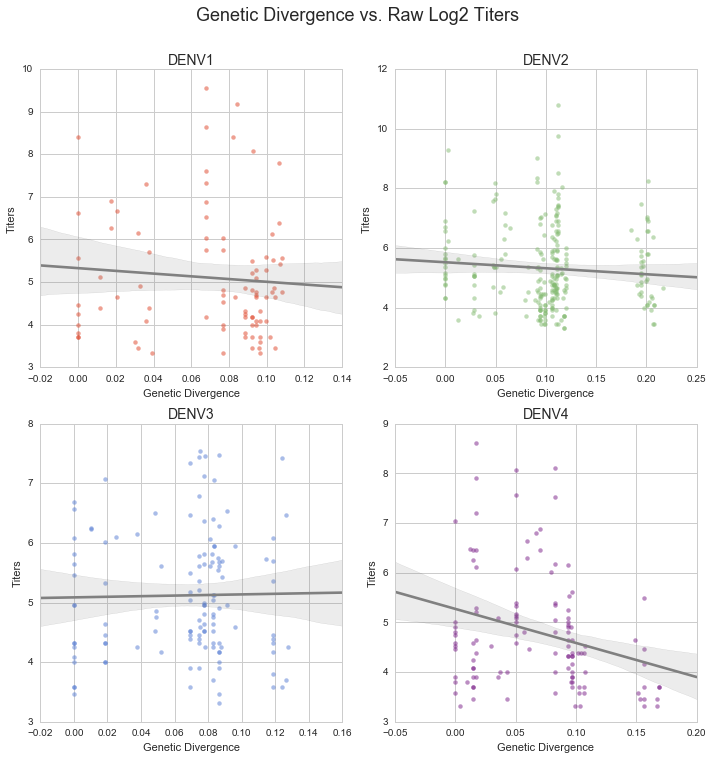

In [66]:
plt.clf()
split_raw_data = split_serotypes(log2_titers_matrix)
s1 = pd.DataFrame(make_tidy_data(divergence, split_raw_data[1][1], 'Autologous'))
s2 = pd.DataFrame(make_tidy_data(divergence, split_raw_data[2][2], 'Autologous'))
s3 = pd.DataFrame(make_tidy_data(divergence, split_raw_data[3][3], 'Autologous'))
s4 = pd.DataFrame(make_tidy_data(divergence, split_raw_data[4][4], 'Autologous'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, squeeze = True, figsize=(10,10))
ax1.set_title('DENV1', size=14)
ax2.set_title('DENV2', size=14)
ax3.set_title('DENV3', size=14)
ax4.set_title('DENV4', size=14)
fig.suptitle('Genetic Divergence vs. Raw Log2 Titers', size=18, y=1.05)
sns.regplot('Genetic Divergence', 'Titers', data=s1, ax=ax1, color='gray',
            scatter_kws={'color': colors['DENV1'], 'alpha': 0.5})

sns.regplot('Genetic Divergence', 'Titers', data=s2, ax=ax2, color='gray',
            scatter_kws={'color':colors['DENV2'], 'alpha': 0.5})

sns.regplot('Genetic Divergence', 'Titers', data=s3, ax=ax3, color='gray',
            scatter_kws={'color':colors['DENV3'], 'alpha': 0.5})

sns.regplot('Genetic Divergence', 'Titers', data=s4, ax=ax4, color='gray',
            scatter_kws={'color':colors['DENV4'], 'alpha': 0.5})

plt.tight_layout()

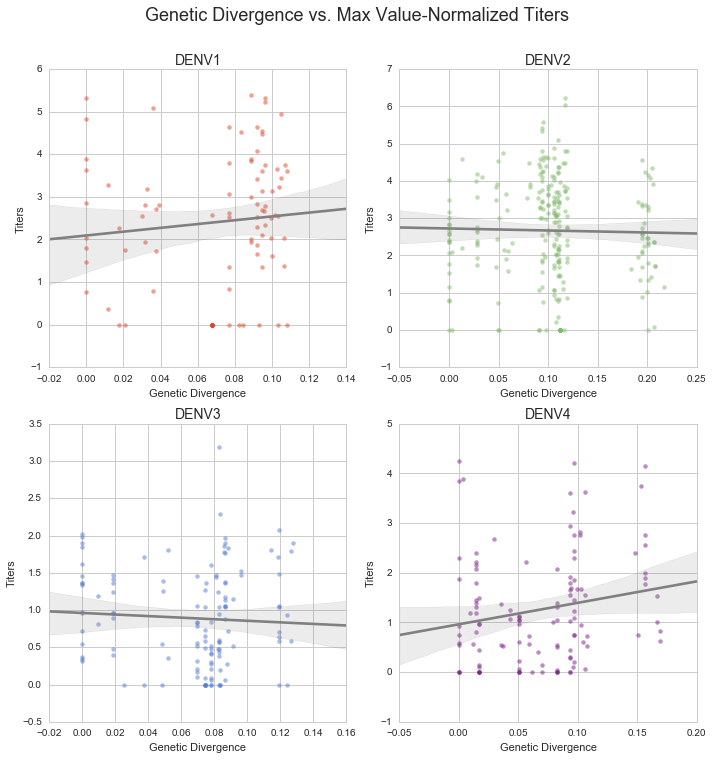

In [62]:
plt.clf()
split_maxnorm_data = split_serotypes(max_normalized_titers_matrix)
s1 = pd.DataFrame(make_tidy_data(divergence, split_maxnorm_data[1][1], 'Max'))
s2 = pd.DataFrame(make_tidy_data(divergence, split_maxnorm_data[2][2], 'Max'))
s3 = pd.DataFrame(make_tidy_data(divergence, split_maxnorm_data[3][3], 'Max'))
s4 = pd.DataFrame(make_tidy_data(divergence, split_maxnorm_data[4][4], 'Max'))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, squeeze = True, figsize=(10,10))
ax1.set_title('DENV1', size=14)
ax2.set_title('DENV2', size=14)
ax3.set_title('DENV3', size=14)
ax4.set_title('DENV4', size=14)
fig.suptitle('Genetic Divergence vs. Max Value-Normalized Titers', size=18, y=1.05)
sns.regplot('Genetic Divergence', 'Titers', data=s1, ax=ax1, color='gray',
            scatter_kws={'color': colors['DENV1'], 'alpha': 0.5})

sns.regplot('Genetic Divergence', 'Titers', data=s2, ax=ax2, color='gray',
            scatter_kws={'color':colors['DENV2'], 'alpha': 0.5})

sns.regplot('Genetic Divergence', 'Titers', data=s3, ax=ax3, color='gray',
            scatter_kws={'color':colors['DENV3'], 'alpha': 0.5})

sns.regplot('Genetic Divergence', 'Titers', data=s4, ax=ax4, color='gray',
            scatter_kws={'color':colors['DENV4'], 'alpha': 0.5})

plt.tight_layout()

In [63]:
## Alt. way to plot divergence vs. titers for each normalization method. I don't like lmplot as much.

# datapoints = []
# datapoints += make_tidy_data(divergence, log2_titers_matrix, 'Raw Log2 Titers')
# datapoints += make_tidy_data(divergence, max_normalized_titers_matrix, 'Max Value Normalized')
# datapoints += make_tidy_data(divergence, autologous_normalized_titers_matrix, 'Autologous Value Normalized')

# tidy_norm_comparisons = pd.DataFrame(datapoints)


# sns.axes_style("whitegrid")
# g = sns.lmplot(x="Genetic Divergence", y="Titers",ci=None,data=tidy_norm_comparisons, col="Normalization",
#     palette="deep",col_wrap=3,scatter_kws={"s": 100,"alpha":.5},
#     line_kws={"lw":4,"alpha":0.5}),hue="Serotype",size=6)

# # remove the top and right line in graph
# sns.despine()
# # Additional line to adjust some appearance issue
# # plt.subplots_adjust(top=0.9)

# g.set_xlabels("Genetic Divergence",size = 14)
# g.set_ylabels("Titers",size = 14)

# # Set the ticklabel size and color of the graph from here
# titles = ['Raw Log2 Titers','Max Value\nNormalized Titers','Autologous Value\nNormalized Titers']
# for ax,title in zip(g.axes.flat,titles):
#     ax.set_title(title, size=18)
#     ax.tick_params(labelsize=14,labelcolor="black")